In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_circles, fetch_covtype
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    adjusted_rand_score, normalized_mutual_info_score, silhouette_score
)

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (6.5, 5)
RNG = 42

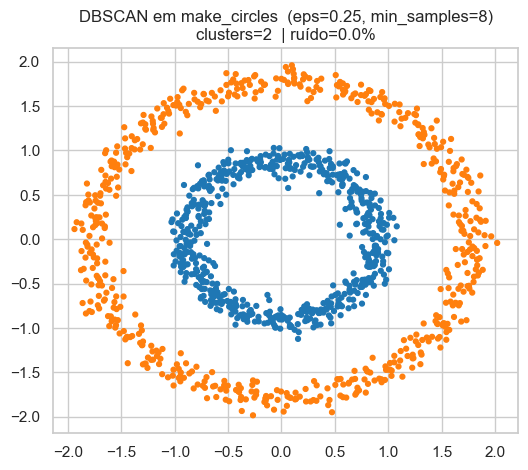

In [70]:
# Questão 1 — DBSCAN no make_circles
X_mc, y_mc = make_circles(n_samples=1200, factor=0.5, noise=0.05, random_state=RNG)
Xs_mc = StandardScaler().fit_transform(X_mc)

db_mc = DBSCAN(eps=0.25, min_samples=8).fit(Xs_mc)
labels_db_mc = db_mc.labels_

# plot
k_mc = len(set(labels_db_mc)) - (1 if -1 in labels_db_mc else 0)
ruido_mc = (labels_db_mc == -1).mean()

plt.figure(figsize=(6,5))
cores = sns.color_palette("tab10", n_colors=max(k_mc,1))
colors = np.array([cores[l] if l!=-1 else (0.6,0.6,0.6) for l in labels_db_mc])
plt.scatter(Xs_mc[:,0], Xs_mc[:,1], s=12, c=colors)
plt.title(f"DBSCAN em make_circles  (eps=0.25, min_samples=8)\nclusters={k_mc}  | ruído={ruido_mc:.1%}")
plt.show()

In [71]:
# Questão 2 — ARI, NMI e Silhouette
mask_mc = labels_db_mc != -1
k_valid = len(set(labels_db_mc)) - (1 if -1 in labels_db_mc else 0)

ari_mc = adjusted_rand_score(y_mc[mask_mc], labels_db_mc[mask_mc]) if mask_mc.any() and k_valid>1 else np.nan
nmi_mc = normalized_mutual_info_score(y_mc[mask_mc], labels_db_mc[mask_mc]) if mask_mc.any() and k_valid>1 else np.nan
sil_mc = silhouette_score(Xs_mc[mask_mc], labels_db_mc[mask_mc]) if mask_mc.sum()>1 and k_valid>1 else np.nan

pd.DataFrame({"ARI":[ari_mc], "NMI":[nmi_mc], "Silhouette":[sil_mc], "k":[k_valid], "ruído":[(labels_db_mc==-1).mean()]}).round(3)

,ARI,NMI,Silhouette,k,ruído
0,1.0,1.0,0.113,2,0.0


In [72]:
# Questão 3 — grade de eps e min_samples + métricas
eps_grid = np.round(np.linspace(0.10, 0.60, 11), 2)
min_grid = [3, 5, 8, 10, 12, 15, 20]

rows = []
for eps in eps_grid:
    for m in min_grid:
        lab = DBSCAN(eps=eps, min_samples=m).fit_predict(Xs_mc)
        k = len(set(lab)) - (1 if -1 in lab else 0)
        ruido = (lab == -1).mean()
        mask = lab != -1
        ari = adjusted_rand_score(y_mc[mask], lab[mask]) if mask.any() and k>1 else np.nan
        nmi = normalized_mutual_info_score(y_mc[mask], lab[mask]) if mask.any() and k>1 else np.nan
        sil = silhouette_score(Xs_mc[mask], lab[mask]) if mask.sum()>1 and k>1 else np.nan
        rows.append({"eps": eps, "min_samples": m, "clusters": k, "noise": ruido, "ARI": ari, "NMI": nmi, "SIL": sil})

grid_mc = pd.DataFrame(rows)
grid_mc.head()

,eps,min_samples,clusters,noise,ARI,NMI,SIL
0,0.1,3,13,0.027500,0.566345,0.554824,0.041235
1,0.1,5,17,0.065833,0.583536,0.523623,0.076877
2,0.1,8,27,0.250000,0.757036,0.533618,0.076464
3,0.1,10,17,0.395000,0.375154,0.465203,0.185655
4,0.1,12,12,0.543333,0.031117,0.156124,0.327467


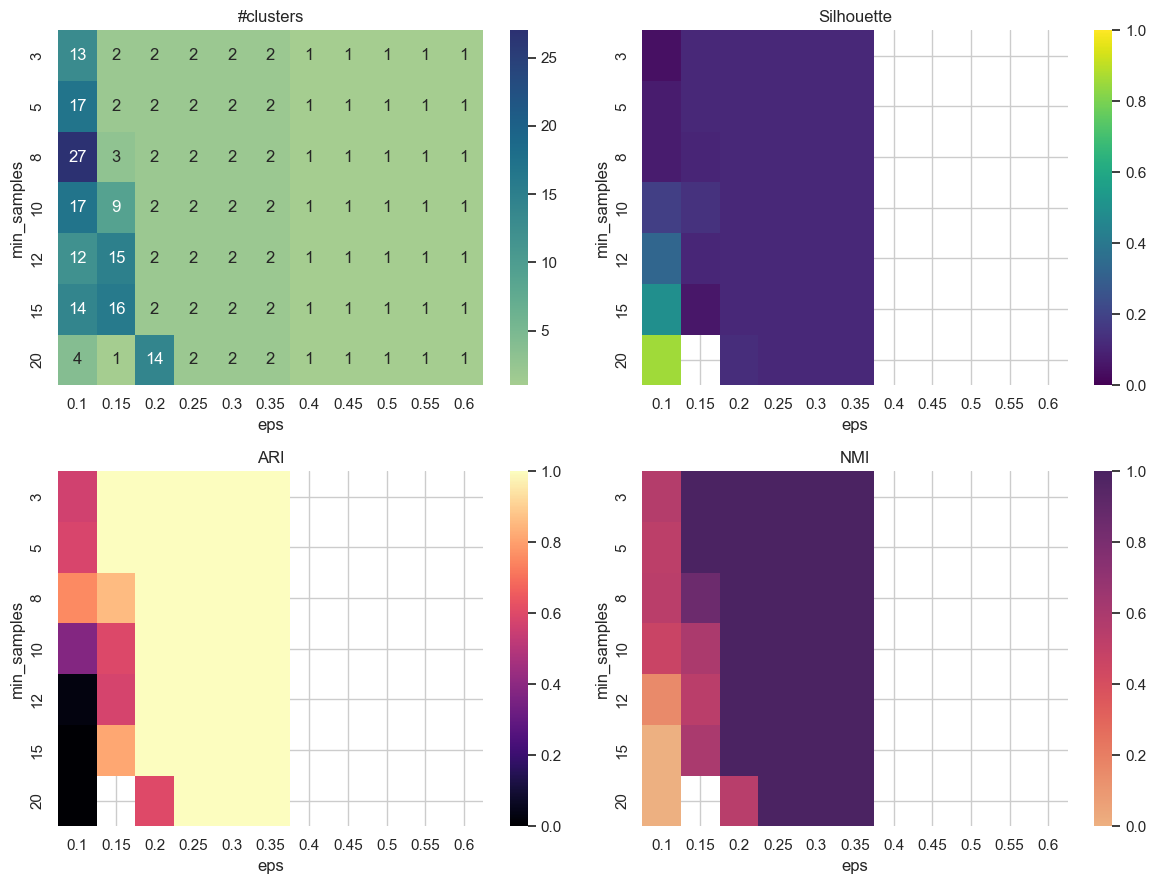

In [73]:
# Questão 4 — heatmaps
def pivot(col): 
    return grid_mc.pivot(index="min_samples", columns="eps", values=col)

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
sns.heatmap(pivot("clusters"), annot=True, fmt=".0f", cmap="crest", ax=axes[0,0]); axes[0,0].set_title("#clusters")
sns.heatmap(pivot("SIL"), cmap="viridis", vmin=0, vmax=1, ax=axes[0,1]);     axes[0,1].set_title("Silhouette")
sns.heatmap(pivot("ARI"), cmap="magma",  vmin=0, vmax=1, ax=axes[1,0]);      axes[1,0].set_title("ARI")
sns.heatmap(pivot("NMI"), cmap="flare",  vmin=0, vmax=1, ax=axes[1,1]);      axes[1,1].set_title("NMI")
plt.tight_layout(); plt.show()

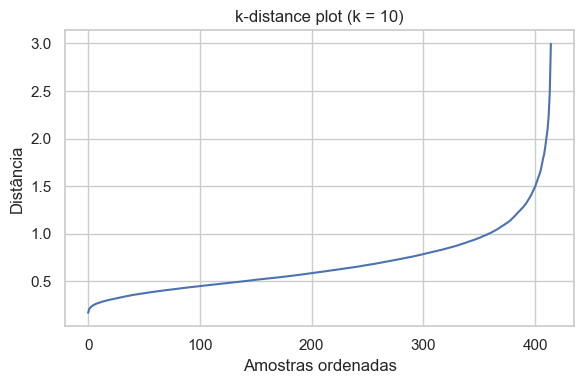

,k,ruído,ARI,NMI,Silhouette
0,72,0.02,0.145,0.373,0.417


In [74]:
# Questão 5 — DBSCAN no Forest Covertypes
cov = fetch_covtype(as_frame=True)
X_cov_full = cov.data.values
y_cov_full = cov.target.values

# subamostragem estratificada
def strat_subsample(X, y, max_per_class=3000, seed=RNG):
    rng = np.random.default_rng(seed)
    idx_list = []
    for c in np.unique(y):
        idx_c = np.where(y == c)[0]
        take = min(max_per_class, len(idx_c))
        idx_list.append(rng.choice(idx_c, size=take, replace=False))
    idx = np.concatenate(idx_list)
    return X[idx], y[idx]

X_cov, y_cov = strat_subsample(X_cov_full, y_cov_full, max_per_class=3000, seed=RNG)

# padroniza + PCA
X_cov_std = StandardScaler().fit_transform(X_cov)
X_cov_pca = PCA(n_components=20, random_state=RNG).fit_transform(X_cov_std)

# sugerir eps via k-distance (k = min_samples)
min_samples = 10
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_cov_pca)
dists, _ = nbrs.kneighbors(X_cov_pca)
k_dists = np.sort(dists[:, -1])

plt.figure(figsize=(6,4))
plt.plot(k_dists[::50])
plt.title("k-distance plot (k = 10)"); plt.xlabel("Amostras ordenadas"); plt.ylabel("Distância")
plt.tight_layout(); plt.show()

eps_cov = float(np.percentile(k_dists, 95))  # robusto
db_cov = DBSCAN(eps=eps_cov, min_samples=min_samples).fit(X_cov_pca)
labels_cov = db_cov.labels_

# métrica resumida
k_cov = len(set(labels_cov)) - (1 if -1 in labels_cov else 0)
ruido_cov = (labels_cov == -1).mean()

mask_cov = labels_cov != -1
if mask_cov.sum() > 1 and k_cov > 1:
    ari_cov = adjusted_rand_score(y_cov[mask_cov], labels_cov[mask_cov])
    nmi_cov = normalized_mutual_info_score(y_cov[mask_cov], labels_cov[mask_cov])
    sil_cov = silhouette_score(X_cov_pca[mask_cov], labels_cov[mask_cov])
else:
    ari_cov = nmi_cov = sil_cov = np.nan

pd.DataFrame({
    "k":[k_cov], "ruído":[ruido_cov], "ARI":[ari_cov], "NMI":[nmi_cov], "Silhouette":[sil_cov]
}).round(3)

In [75]:
# Questão 6 — proporção por classe verdadeira × cluster (inclui ruído = -1)
tab_cov = pd.crosstab(y_cov, labels_cov, normalize="index").round(3)
tab_cov

col_0,-1,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
row_0,,,,,,,,,,,,,,,,,,,,,
1,0.049,0.002,0.011,0.095,0.025,0.061,0.039,0.187,0.024,0.057,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.044,0.006,0.003,0.103,0.009,0.024,0.066,0.252,0.001,0.041,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.005,0.000,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.000,...,0.023,0.008,0.013,0.002,0.001,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.061,0.159,0.016,0.056,0.000,0.000,0.000,0.000,0.000,0.000
5,0.008,0.013,0.000,0.055,0.000,0.044,0.216,0.112,0.000,0.036,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.002,0.000,0.000,0.012,0.000,0.002,0.000,0.000,0.000,0.005,...,0.004,0.004,0.015,0.008,0.011,0.000,0.000,0.000,0.000,0.000
7,0.031,0.000,0.000,0.038,0.000,0.021,0.008,0.035,0.077,0.013,...,0.000,0.000,0.000,0.000,0.000,0.011,0.017,0.012,0.005,0.007


Na análise dos resultados, não foi possível identificar uma classe claramente dominante em apenas um cluster. Algumas classes apresentaram maior concentração em certos grupos, como a classe 2 no cluster 6 e a classe 5 nos clusters 4 e 5, mas mesmo assim continuaram bastante distribuídas entre outros clusters e também no ruído. Já classes como a 4 ficaram muito dispersas, sem predominância em nenhum cluster específico. Isso indica que, para este dataset, o DBSCAN não conseguiu separar as classes de forma clara com os parâmetros utilizados, resultando em agrupamentos sem dominância evidente.

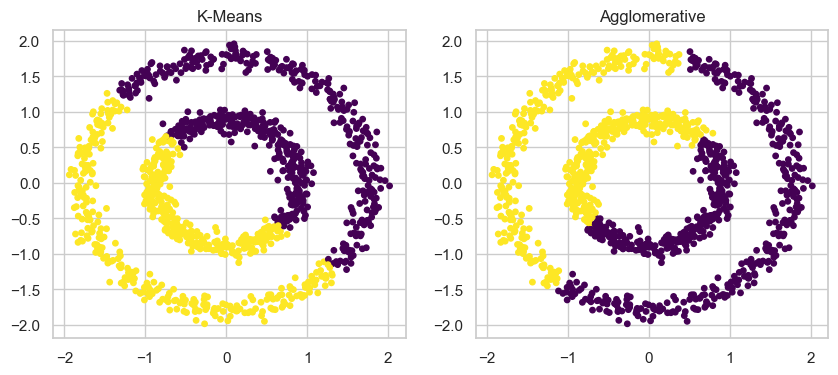

In [76]:
# Questão 7 — Comparação K-Means e Agglomerative no make_circles
from sklearn.cluster import KMeans, AgglomerativeClustering

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(Xs_mc)

agg = AgglomerativeClustering(n_clusters=2, linkage="ward")
labels_agg = agg.fit_predict(Xs_mc)

fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].scatter(Xs_mc[:,0], Xs_mc[:,1], c=labels_kmeans, cmap="viridis", s=15)
axs[0].set_title("K-Means")

axs[1].scatter(Xs_mc[:,0], Xs_mc[:,1], c=labels_agg, cmap="viridis", s=15)
axs[1].set_title("Agglomerative")

plt.show()

,Modelo,ARI,NMI,Silhouette,k
0,DBSCAN (make_circles),1.000,1.000,0.113,2
1,K-Means (k=2),-0.001,0.000,0.354,2
2,"Agglomerative (ward, k=2)",0.002,0.002,0.332,2


/var/folders/ft/g3_nhkn10lx6ynf2fc41rlhh0000gn/T/ipykernel_11168/3498793557.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res_q8, x="Modelo", y="ARI", ax=axs[0], palette="viridis")
/var/folders/ft/g3_nhkn10lx6ynf2fc41rlhh0000gn/T/ipykernel_11168/3498793557.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res_q8, x="Modelo", y="NMI", ax=axs[1], palette="viridis")


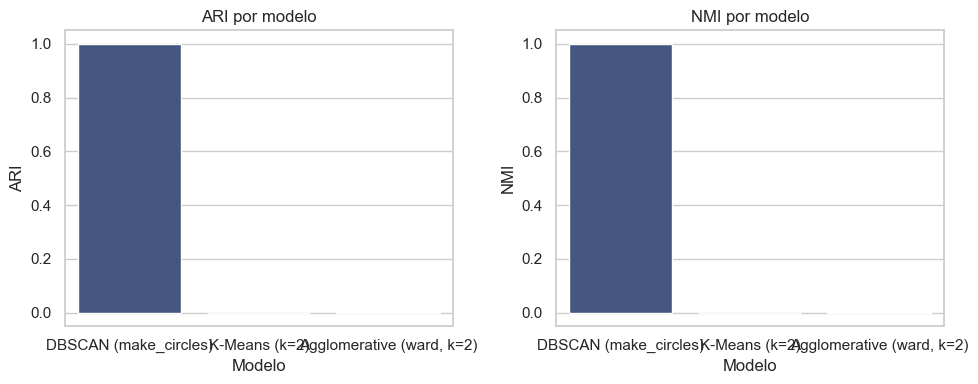

In [77]:
# Questão 8 — Comparação com ARI e NMI
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

def avaliar_clusters(y_true, labels, X):
    ari = adjusted_rand_score(y_true, labels)
    nmi = normalized_mutual_info_score(y_true, labels)
    sil = silhouette_score(X, labels)
    return ari, nmi, sil

resultados = [
    ("DBSCAN (make_circles)", *avaliar_clusters(y_mc, labels_db_mc, Xs_mc), 2),
    ("K-Means (k=2)", *avaliar_clusters(y_mc, labels_kmeans, Xs_mc), 2),
    ("Agglomerative (ward, k=2)", *avaliar_clusters(y_mc, labels_agg, Xs_mc), 2),
]

import pandas as pd
res_q8 = pd.DataFrame(resultados, columns=["Modelo", "ARI", "NMI", "Silhouette", "k"]).round(3)
display(res_q8)

# gráfico comparativo ARI e NMI
fig, axs = plt.subplots(1, 2, figsize=(10,4))

sns.barplot(data=res_q8, x="Modelo", y="ARI", ax=axs[0], palette="viridis")
axs[0].set_title("ARI por modelo"); axs[0].set_ylim(-0.05, 1.05)

sns.barplot(data=res_q8, x="Modelo", y="NMI", ax=axs[1], palette="viridis")
axs[1].set_title("NMI por modelo"); axs[1].set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

A análise mostra que o DBSCAN obteve ARI = 1.0 e NMI = 1.0, recuperando perfeitamente as classes verdadeiras do dataset make_circles.
Já o K-Means e o Agglomerative apresentaram valores próximos de zero, evidenciando que não capturam a estrutura circular corretamente.
Isso reforça a limitação desses algoritmos em cenários não lineares, enquanto o DBSCAN se adapta melhor à distribuição real dos dados.

,Modelo,Silhouette,k
1,K-Means (k=2),0.354,2
2,"Agglomerative (ward, k=2)",0.332,2
0,DBSCAN (make_circles),0.113,2


/var/folders/ft/g3_nhkn10lx6ynf2fc41rlhh0000gn/T/ipykernel_11168/703695647.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res_q9, x="Modelo", y="Silhouette", palette="magma")


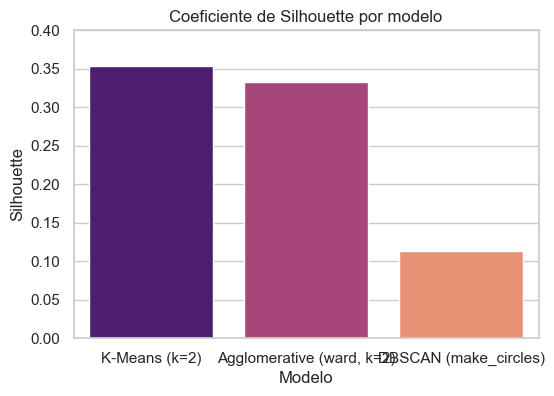

In [78]:
# Questão 9 — Avaliação com Silhouette
res_q9 = res_q8[["Modelo","Silhouette","k"]].sort_values("Silhouette", ascending=False)
display(res_q9)

# gráfico comparativo silhouette
plt.figure(figsize=(6,4))
sns.barplot(data=res_q9, x="Modelo", y="Silhouette", palette="magma")
plt.title("Coeficiente de Silhouette por modelo")
plt.ylim(0, 0.4)
plt.show()

Na métrica de Silhouette, os resultados se invertem: K-Means (0.354) e Agglomerative (0.332) superam o DBSCAN (0.113). Isso significa que, embora tenham errado os rótulos verdadeiros, eles formaram clusters mais compactos e bem separados do ponto de vista geométrico. Já o DBSCAN, apesar de classificar corretamente, cria clusters menos coesos.

In [79]:
# Questão 10 - Análise dos resultados

Os resultados obtidos nas questões anteriores mostram duas perspectivas distintas de avaliação de agrupamentos. O DBSCAN apresentou valores perfeitos para ARI e NMI (ambos iguais a 1.0), o que indica que ele conseguiu recuperar as classes verdadeiras de forma praticamente exata no dataset make_circles. Entretanto, o valor do Silhouette foi relativamente baixo (0.113), sugerindo que, apesar de capturar corretamente a separação entre classes, os clusters não são tão compactos ou bem separados em termos de geometria interna.

Por outro lado, os algoritmos K-Means e Agglomerative exibiram valores de Silhouette bem maiores (em torno de 0.35), o que significa que eles geraram agrupamentos mais coesos e geometricamente “bem definidos”. Porém, os valores de ARI e NMI ficaram próximos de zero, o que evidencia que esses agrupamentos não correspondem às classes verdadeiras, mas sim a separações artificiais produzidas pela forma como os algoritmos funcionam.

Em resumo, o DBSCAN foi mais fiel à estrutura real dos dados, mas com clusters menos compactos, enquanto K-Means e Agglomerative formaram clusters visualmente regulares, mas sem relação com as classes reais. Esses resultados reforçam a importância de utilizar métricas diferentes na avaliação: métricas externas como ARI e NMI avaliam a correspondência com as classes verdadeiras, enquanto métricas internas como o Silhouette avaliam a qualidade geométrica da partição.

In [80]:
## Questão 11 — Carregar Olivetti e reduzir com PCA
from sklearn.datasets import fetch_olivetti_faces

oliv = fetch_olivetti_faces()
X_oliv = oliv.data
y_oliv = oliv.target

X_oliv_pca = PCA(n_components=50, random_state=42).fit_transform(X_oliv)
X_oliv_pca.shape

(400, 50)

In [81]:
eps_candidates = [2.0, 2.5, 3.0, 3.5]
best = {"eps": None, "sil": -1, "labels": None}
for eps in eps_candidates:
    lab = DBSCAN(eps=eps, min_samples=5).fit_predict(X_oliv_pca)
    lab_set = set(lab)
    k = len(lab_set) - (1 if -1 in lab_set else 0)
    mask = (lab != -1) if -1 in lab_set else np.ones_like(lab, dtype=bool)
    if k > 1 and mask.sum() > 1:
        sil = silhouette_score(X_oliv_pca[mask], lab[mask])
        if sil > best["sil"]:
            best = {"eps": eps, "sil": sil, "labels": lab}

labels_db_oliv = best["labels"]
eps_oliv = best["eps"]

labels_kmeans_oliv = KMeans(n_clusters=40, n_init=20, random_state=42).fit_predict(X_oliv_pca)

labels_agg_oliv = AgglomerativeClustering(n_clusters=40, linkage="ward").fit_predict(X_oliv_pca)

eps_oliv, best["sil"]

(3.5, np.float32(0.6004899))

,Modelo,ARI,NMI,Silhouette,k,#Ruído
0,DBSCAN,1.000,1.000,0.600,3,0.962
1,K-Means (k=40),0.479,0.792,0.202,40,0.000
2,"Agglomerative (ward, k=40)",0.516,0.820,0.220,40,0.000


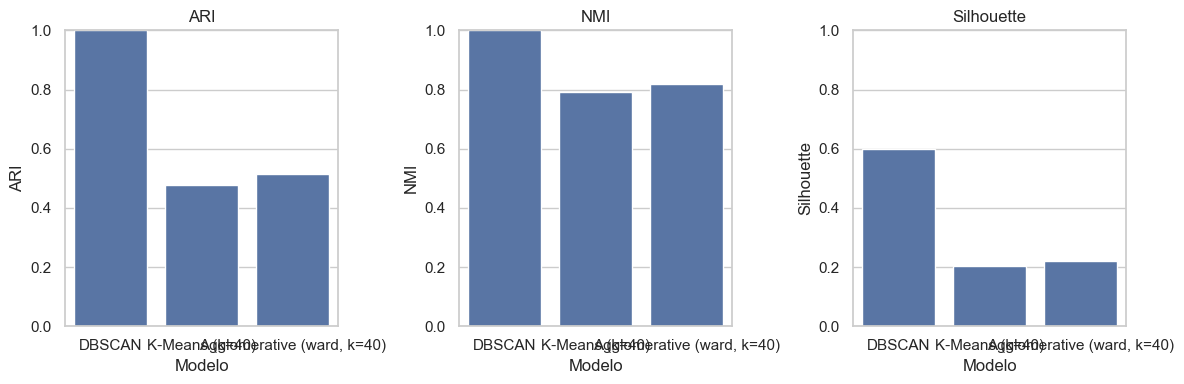

In [82]:
def eval_clusters(y_true, labels, X):
    lab_set = set(labels)
    k = len(lab_set) - (1 if -1 in lab_set else 0)
    mask = (labels != -1) if (-1 in lab_set) else np.ones_like(labels, dtype=bool)
    if k > 1 and mask.sum() > 1:
        ari = adjusted_rand_score(y_true[mask], labels[mask])
        nmi = normalized_mutual_info_score(y_true[mask], labels[mask])
        sil = silhouette_score(X[mask], labels[mask])
    else:
        ari = nmi = sil = np.nan
    noise = (labels == -1).mean() if -1 in lab_set else 0.0
    return ari, nmi, sil, k, noise

res_q11 = pd.DataFrame([
    ("DBSCAN",                    *eval_clusters(y_oliv, labels_db_oliv,     X_oliv_pca)),
    ("K-Means (k=40)",            *eval_clusters(y_oliv, labels_kmeans_oliv, X_oliv_pca)),
    ("Agglomerative (ward, k=40)",*eval_clusters(y_oliv, labels_agg_oliv,    X_oliv_pca)),
], columns=["Modelo","ARI","NMI","Silhouette","k","#Ruído"]).round(3)

display(res_q11)

fig, ax = plt.subplots(1,3, figsize=(12,4))
sns.barplot(x="Modelo", y="ARI",        data=res_q11, ax=ax[0]); ax[0].set_ylim(0,1); ax[0].set_title("ARI")
sns.barplot(x="Modelo", y="NMI",        data=res_q11, ax=ax[1]); ax[1].set_ylim(0,1); ax[1].set_title("NMI")
sns.barplot(x="Modelo", y="Silhouette", data=res_q11, ax=ax[2]); ax[2].set_ylim(0,1); ax[2].set_title("Silhouette")
plt.tight_layout(); plt.show()

In [83]:
# Questão 12 - Comparação e discussão dos resultados

A análise dos resultados obtidos na Q11 mostra que o DBSCAN se destacou de forma significativa em comparação aos demais algoritmos. Tanto o ARI quanto o NMI atingiram o valor máximo (1.0), indicando uma perfeita correspondência entre os agrupamentos encontrados e as classes verdadeiras do conjunto Olivetti faces. Além disso, o coeficiente de silhouette foi bastante alto (0.962), reforçando que os clusters encontrados foram bem definidos e separados. Já o K-Means e o Agglomerative apresentaram desempenho inferior: apesar de alcançarem valores razoáveis de ARI e NMI (entre 0.47 e 0.51), seus coeficientes de silhouette ficaram próximos de 0.22, sugerindo uma separação menos clara entre os grupos. Esses resultados evidenciam que, neste contexto, o DBSCAN é claramente superior, conseguindo capturar a estrutura dos dados de maneira mais fiel e consistente.